In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# add code directory to path
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), 'code'))

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
from config import load_config

In [6]:
config = load_config("config_original_paper.yaml")
sequences_df = pd.read_csv(config["dataset_path"])

Loaded configuration:
  root_path: /home/labs/fleishman/omripo/Projects/adaptive_learning
  data_dir_name: data
  pretraining_dir_name: pretraining
  bootstrap_dir_name: bootstrap
  results_dir_name: results
  enzyme: PTE
  substrate: malathion
  dataset_filename: llm_input_original_paper.csv
  tag: clustering_funclib_paper
  weights_filename: final_model.pt
  model_type: plm
  finetune: False
  opmode: mean
  train_type: msa_backbone
  nmuts_column: num_muts
  sequence_column_name: full_seq
  activity_column_name: inactive
  first_column_name: I106
  last_column_name: M317
  plm_name: esm2_t12_35M_UR50D
  ref_seq: DRINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALAEKAVRGLRRARAAGVRTIVDVSTFDIGRDVSLLAEVSRAADVHIVAATGLWFDPPLSMRLRSVEELTQFFLREIQYGIEDTGIRAGIIKVATTGKATPFQELVLKAAARASLATGVPVTTHTAASQRDGEQQAAIFESEGLSPSRVCIGHSDDTDDLSYLTALAARGYLIGLDHIPHSAIGLEDNASASALLGIRSWQTRALLIKALIDQGYMKQILVSNDWLFGFSSYVTNIMDVMDRVNPDGMAFIPLRVIPFLREKGVPQETLAGITVTNPARFLSPTLRAS
  bootstrap_indices_prefix: indices
  train_i

In [7]:
from bootstrap import get_oh_table

In [8]:
oh_funclib_df, y, design_numbers = get_oh_table(
    config["dataset_path"],
    first_col=config["first_column_name"],
    last_col=config["last_column_name"],
    y_col="activity"
)
log_y = np.log(y + 1e-6)  # avoid log(0)

In [10]:
oh_funclib_df

,I106_C,I106_H,I106_I,I106_L,I106_M,F132_F,F132_L,H254_G,H254_H,H254_R,...,H257_Y,L271_I,L271_L,L271_R,L303_L,L303_T,F306_F,F306_I,M317_L,M317_M
0,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,True,False,True,False,False,True
13,False,False,False,True,False,True,False,False,False,True,...,True,False,True,False,True,False,True,False,True,False
20,False,False,False,True,False,True,False,False,False,True,...,False,True,False,False,True,False,False,True,True,False
27,True,False,False,False,False,True,False,False,False,True,...,False,False,False,True,False,True,False,True,False,True
49,True,False,False,False,False,True,False,True,False,False,...,False,False,True,False,False,True,False,True,True,False
53,True,False,False,False,False,True,False,False,False,True,...,False,False,True,False,True,False,True,False,True,False
97,False,False,False,True,False,True,False,False,False,True,...,True,False,True,False,True,False,False,True,False,True
98,True,False,False,False,False,True,False,False,False,True,...,False,False,True,False,False,True,True,False,False,True
102,False,False,True,False,False,True,False,False,False,True,...,False,False,True,False,False,True,True,False,True,False
143,True,False,False,False,False,True,False,False,True,False,...,False,False,True,False,False,True,True,False,True,False


In [9]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [10]:
mlp_reg_oh = MLPRegressor(
            hidden_layer_sizes=(128),
            activation="relu",
            learning_rate="invscaling",
            solver="lbfgs",
            random_state=42,
            verbose=True,
            max_iter=20000,
    )

In [11]:
mlp_reg_oh.fit(oh_funclib_df.values, log_y)

,loss,'squared_error'
,hidden_layer_sizes,128
,activation,'relu'
,solver,'lbfgs'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'invscaling'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,20000
,shuffle,True


In [12]:
pred_weights = pd.DataFrame(
        np.eye(len(oh_funclib_df.columns)), columns=oh_funclib_df.columns
    )
predictions = mlp_reg_oh.predict(pred_weights)
results = pd.DataFrame([i.split("_") for i in oh_funclib_df.columns], columns=["position", "AA"])
results["predictions"] = predictions
results_sorted = results.sort_values("predictions", ascending=False, inplace=False)

/home/labs/fleishman/omripo/Projects/adaptive_learning/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [13]:
results_sorted

,position,AA,predictions
3,I106,L,2.820751
9,H254,R,1.025695
0,I106,C,0.886558
17,L303,T,0.673337
11,H257,W,0.588210
2,I106,I,0.544176
6,F132,L,0.194753
14,L271,L,0.128697
18,F306,F,-0.131090
20,M317,L,-0.170599


In [16]:
from itertools import combinations

In [17]:
results_list = []
for position in results["position"].unique():
    positon_df = results[results["position"] == position]
    # get all possible distinct AA combinations
    AA_combinations = list(combinations(positon_df["AA"], 2))
    
    # iter over combinations
    for AA_combination in AA_combinations:
        # get the two rows
        row1 = positon_df[positon_df["AA"] == AA_combination[0]]
        row2 = positon_df[positon_df["AA"] == AA_combination[1]]
        # get the difference
        diff = row1["predictions"].values[0] - row2["predictions"].values[0]
        results_list.append(
            {
                "position": position,
                "AA1": AA_combination[0],
                "AA2": AA_combination[1],
                "diff": diff,
            }
        )
        results_list.append(
            {
                "position": position,
                "AA1": AA_combination[1],
                "AA2": AA_combination[0],
                "diff": -diff,
            }
        )
results_df = pd.DataFrame(results_list)
results_df.sort_values("diff", ascending=False, inplace=True)

In [19]:
results_df[results_df["diff"] <= -10]

,position,AA1,AA2,diff
21,F132,L,F,-11.175529
37,L271,R,I,-19.930798
35,L271,L,I,-20.104023
28,H257,H,W,-62.127134
33,H257,Y,W,-62.242741
14,I106,I,L,-216.646322
4,I106,C,L,-217.215094
19,I106,M,L,-220.022074
10,I106,H,L,-221.949788


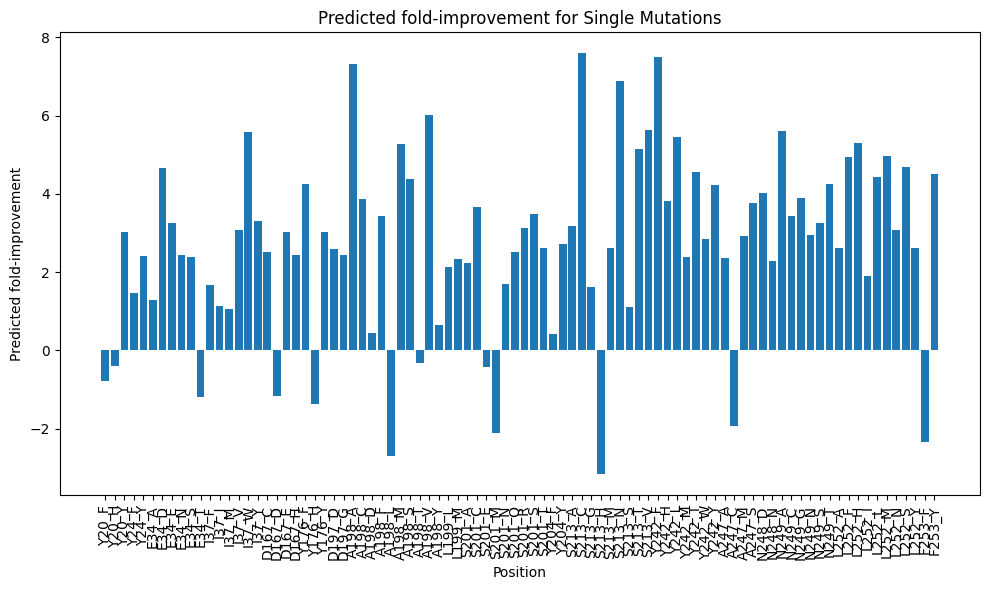

In [47]:
# plot the predictions
plt.figure(figsize=(10, 6))
neg_log = lambda x: np.log(x) if x > 0 else -np.log(-x)
# apply neg_log to predictions
neg_log_predictions = np.array([neg_log(x) for x in predictions])
plt.bar(range(len(predictions)), neg_log_predictions)
plt.xlabel("Position")
plt.ylabel(f"Predicted fold-improvement")
plt.title(f"Predicted fold-improvement for Single Mutations")
plt.xticks(range(len(predictions)), oh_funclib_df.columns, rotation=90)
plt.tight_layout()
plt.show()

In [37]:
# epistasis analysis
# positions 201 and 213
# list(combinations(results["AA"], 2))
s213_df = results[results["position"] == "S213"]
s201_df = results[results["position"] == "S201"]
# create an empty_series based on oh_funclib_df columns
empty_series = pd.Series(0, index=oh_funclib_df.columns)
pairs_list = []
s213_aas = []
s201_aas = []
for i, row1 in s213_df.iterrows():
    for j, row2 in s201_df.iterrows():
        # create a copy of empty_series
        combo_series = empty_series.copy()
        # set the two mutations to 1
        combo_series[f"S213_{row1['AA']}"] = 1
        s213_aas.append(row1['AA'])
        combo_series[f"S201_{row2['AA']}"] = 1
        s201_aas.append(row2['AA'])
        pairs_list.append(combo_series)
pairs_df = pd.DataFrame(pairs_list)
pair_predictions = mlp_reg_oh.predict(pairs_df.values)
pair_results = pd.DataFrame({
    "S213_AA": s213_aas,
    "S201_AA": s201_aas,
    "predictions": pair_predictions
})
pair_results.sort_values("predictions", ascending=False, inplace=True)
pair_results


,S213_AA,S201_AA,predictions
12,C,M,1930.420670
17,C,T,1862.701719
13,C,N,1854.550813
11,C,E,1848.061632
15,C,R,1841.974537
...,...,...,...
27,H,A,-22.122377
32,H,Q,-25.889861
31,H,N,-29.411900
29,H,E,-30.716674


In [38]:
# "Normalize" the pair results by subtracting the single mutation effects
pair_results["normalized_predictions"] = pair_results.apply(
    lambda row: row["predictions"] -
    results[(results["position"] == "S213") & (results["AA"] == row["S213_AA"])]["predictions"].values[0] -
    results[(results["position"] == "S201") & (results["AA"] == row["S201_AA"])]["predictions"].values[0],
    axis=1
)

pair_results

,S213_AA,S201_AA,predictions,normalized_predictions
12,C,M,1930.420670,-36.802902
17,C,T,1862.701719,-126.341248
13,C,N,1854.550813,-126.322833
11,C,E,1848.061632,-125.873723
15,C,R,1841.974537,-156.010470
...,...,...,...,...
27,H,A,-22.122377,-7.626676
32,H,Q,-25.889861,-14.510053
31,H,N,-29.411900,-11.030649
29,H,E,-30.716674,-5.397132


In [39]:
results[results["position"].isin(["S201", "S213"])]

,position,AA,predictions
38,S201,A,9.293620
39,S201,C,39.450386
40,S201,E,-1.530221
41,S201,M,-8.242004
42,S201,N,5.408070
43,S201,Q,12.409513
44,S201,R,22.519431
45,S201,S,32.294978
46,S201,T,13.577391
49,S213,A,24.077905


In [40]:
# epistasis analysis
# positions 37 and 242
# list(combinations(results["AA"], 2))
i37_df = results[results["position"] == "I37"]
y242_df = results[results["position"] == "Y242"]
# create an empty_series based on oh_funclib_df columns
empty_series = pd.Series(0, index=oh_funclib_df.columns)
pairs_list_37_242 = []
i37_aas = []
y242_aas = []
for i, row1 in i37_df.iterrows():
    for j, row2 in y242_df.iterrows():
        # create a copy of empty_series
        combo_series = empty_series.copy()
        # set the two mutations to 1
        combo_series[f"I37_{row1['AA']}"] = 1
        i37_aas.append(row1['AA'])
        combo_series[f"Y242_{row2['AA']}"] = 1
        y242_aas.append(row2['AA'])
        pairs_list_37_242.append(combo_series)
pairs_df_37_242 = pd.DataFrame(pairs_list_37_242)
pair_predictions_37_242 = mlp_reg_oh.predict(pairs_df_37_242.values)
pair_results_37_242 = pd.DataFrame({
    "I37_AA": i37_aas,
    "Y242_AA": y242_aas,
    "predictions": pair_predictions_37_242
})
pair_results_37_242.sort_values("predictions", ascending=False, inplace=True)
pair_results_37_242

,I37_AA,Y242_AA,predictions
28,W,F,2755.811281
14,M,F,1760.341025
35,Y,F,1743.408326
0,F,F,1561.747686
21,V,F,1530.852320
30,W,L,681.825538
29,W,H,485.597141
7,I,F,397.369543
34,W,Y,289.449767
32,W,T,277.199141


In [41]:
# "Normalize" the pair results by subtracting the single mutation effects
pair_results_37_242["normalized_predictions"] = pair_results_37_242.apply(
    lambda row: row["predictions"] -
    results[(results["position"] == "I37") & (results["AA"] == row["I37_AA"])]["predictions"].values[0] -
    results[(results["position"] == "Y242") & (results["AA"] == row["Y242_AA"])]["predictions"].values[0],
    axis=1
)
pair_results_37_242

,I37_AA,Y242_AA,predictions,normalized_predictions
28,W,F,2755.811281,690.915709
14,M,F,1760.341025,-40.707905
35,Y,F,1743.408326,-81.762415
0,F,F,1561.747686,-241.738451
21,V,F,1530.852320,-288.764218
30,W,L,681.825538,183.825108
29,W,H,485.597141,173.084443
7,I,F,397.369543,-1403.957557
34,W,Y,289.449767,-45.638101
32,W,T,277.199141,-84.473478


In [42]:
results[results["position"].isin(["I37", "Y242"])]

,position,AA,predictions
11,I37,F,5.297193
12,I37,I,3.138156
13,I37,M,2.859986
14,I37,V,21.427594
15,I37,W,266.706628
16,I37,Y,26.981797
58,Y242,F,1798.188944
59,Y242,H,45.806070
60,Y242,L,231.293802
61,Y242,M,10.943495
